In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.setup import data_setup
from gallifrey.utilities.dataframe import aggregated_dataframe, rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 4096
sim_id = "09_18"

In [5]:
ds, mw, stellar_model, imf, planet_model, path = data_setup(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-09-21 09:24:25,884 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-09-21 09:24:25,944 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-09-21 09:24:25,944 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-09-21 09:24:25,945 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-09-21 09:24:25,945 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-09-21 09:24:25,946 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-21 09:24:25,946 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-09-21 09:24:25,946 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-09-21 09:24:25,947 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-09-21 09:24:25,947 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_directory = (
    f"MilkyWayAnalogue/{resolution}/{sim_id}/{snapshot}/Galaxy_properties"
)

## CREATE DATA SOURCE

In [7]:
radius = 80
sphere_data = mw.sphere(radius=(radius, "kpc"))

## GENERAL PROPERTIES

In [8]:
print(
    "Total Stellar Mass : {:.2f} * 10^10 Msun".format(
        np.sum(sphere_data["stars", "Masses"].to("Msun")).value / 1e10
    )
)

Total Stellar Mass : 6.52 * 10^10 Msun


## METALLICITY GRADIENT

In [9]:
metallicity_profile = yt.create_profile(
    sphere_data,
    [("stars", "particle_radius")],
    fields=[("stars", "[Fe/H]")],
    units={("stars", "particle_radius"): "kpc"},
    weight_field=("stars", "total_number"),
)
data = pd.DataFrame(
    np.array([metallicity_profile.x, metallicity_profile["stars", "[Fe/H]"]]).T,
    columns=["Distance (kpc)", "[Fe/H]"],
)

In [10]:
fit_range = (2, 15)

metallicity_gradient = np.polyfit(
    *np.array(data[data["Distance (kpc)"].between(*fit_range)]).T, 1
)[0]
print(f"Metallicity Gradient: {metallicity_gradient} dex/kpc")

Metallicity Gradient: -0.031382869744288854 dex/kpc


<Axes: xlabel='Distance (kpc)', ylabel='[Fe/H]'>

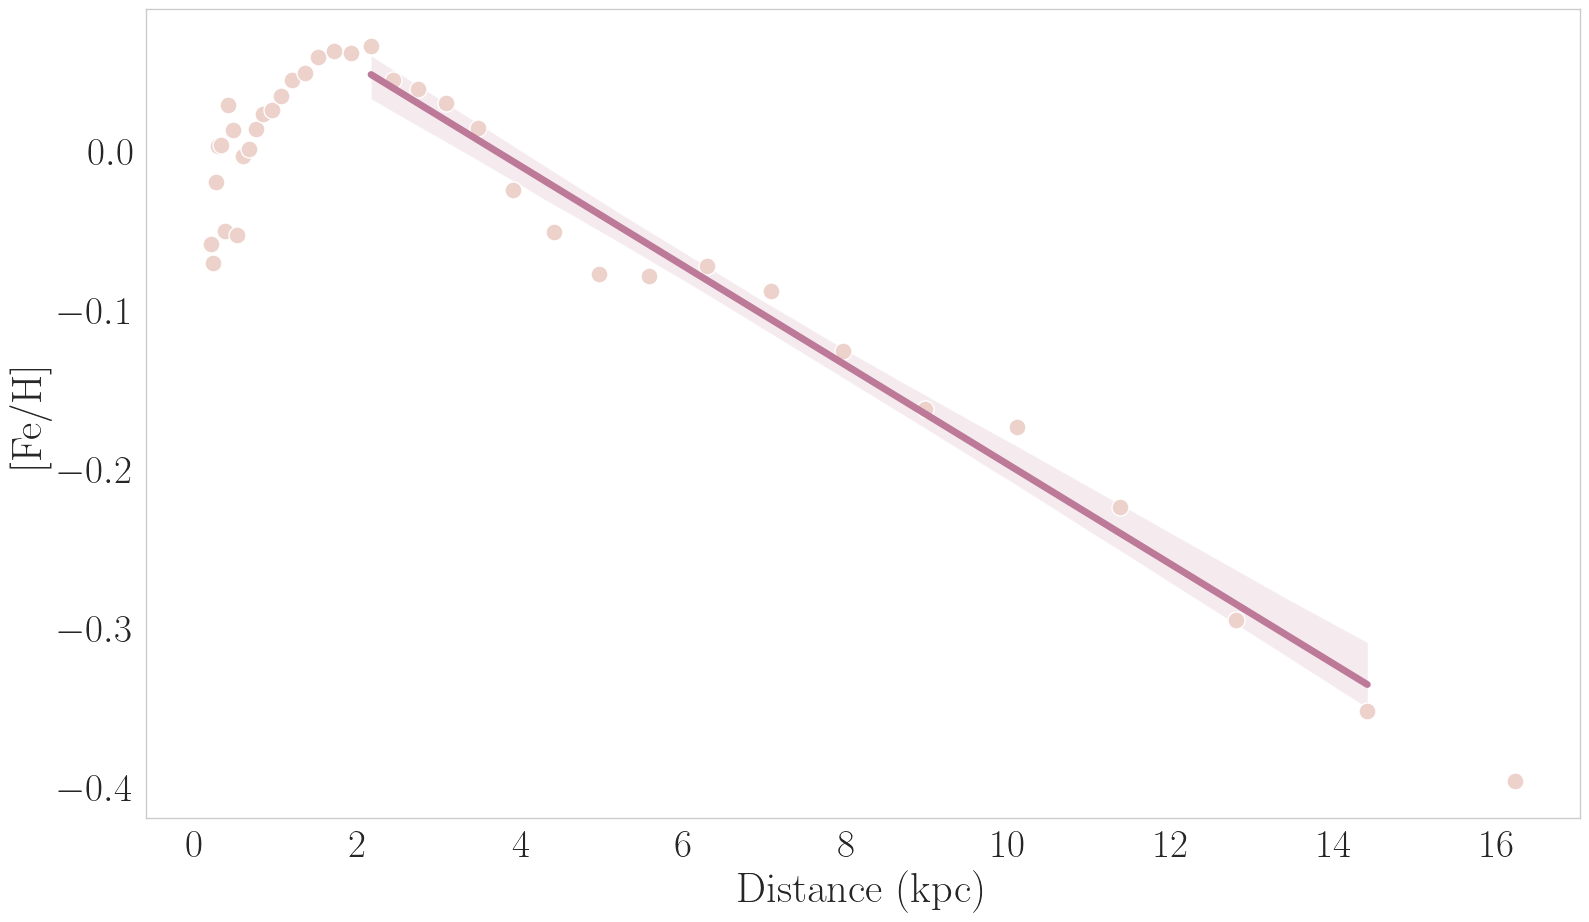

In [11]:
fig, ax = plt.subplots()
sns.regplot(
    data[data["Distance (kpc)"].between(*fit_range)],
    x="Distance (kpc)",
    y="[Fe/H]",
    color=get_palette()[2],
    scatter=False,
    line_kws={"linewidth": 5},
    ax=ax,
)
sns.scatterplot(
    data[data["Distance (kpc)"].between(0.2, 18)],
    x="Distance (kpc)",
    y="[Fe/H]",
    color=get_palette()[0],
    s=150,
    ax=ax,
)